# Task 1.3: Matrix Factorization

Notebook for Matrix Factorization recommender system 
<br> We are running the 5-fold cross validation in parallel, hence the functions for the matrix factorization algorithm are included in a seperated file matrix_fact.py.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle
from multiprocessing import Pool
import defs_upd, matrix_fact

In [2]:
#read the rating data 
df = pd.read_csv('ml-1m/ratings.dat', sep = '::', names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])

/var/folders/zq/kxyb9__d7q11lb0tprf805cr0000gn/T/ipykernel_2055/2921473051.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('ml-1m/ratings.dat', sep = '::', names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])


There are movies in the data for which there are no ratings at all. These are of no interest for our recommender system, so we don't want to have columns of these in our utility matrix. The next cell finds those movies are stores their ID in the 'del_col' array. Note that we don't have to do this for users, for each user we have at least one rating.

In [3]:
#we are looking for movies which are completely missing in the data

y = np.amax(df['MovieID'])   #highest movie ID in the data
movie_Id = np.unique(df['MovieID'])   #all the movie ID's in the data
miss_movieId = []           #list which will store which movie ID's are missing in the data 
for i in range(1, y + 1):   #loop through all possible ID's
    if len(movie_Id[movie_Id == i]) == 0:   #if ID i is not present in the data, we want a record of this
        miss_movieId.append(i)

del_col = np.array(miss_movieId) - 1 #these are the columns to be deleted straightaway in the utility matrix, -1 is needed because indexing begins at 0

The following cell creates 5 sets of rating indexes from the original dataframe df (=ratings.dat). The sets are randomy picked and are of the same size (with exception of the last set which is slightly smaller) and we make sure that there is no overlap between the sets. The sets are later used to generate the 5 training and associated training sets for the 5-fold cross validation. We will store the sets in a dictionary called 'sets'. For example, for the first fold we will use set1, set2, set3 and set4 to create the training data and set5 is used for the test data. Using our method here, we ensure that each training/test set of the 5 folds will have the same number of known ratings (i.e non-zero elements in the utility matrix).

In [4]:
#generate the 5 sets for the 5-fold cross validation

np.random.seed(10)   #our seed for splitting the rating data into 5 oarts
sets = {'set1':[], 'set2':[], 'set3':[], 'set4':[], 'set5':[]}   #dictionary which will store the sets

l = len(df) // 5   #length of a set or number of known ratings in a set 
index_list = np.arange(0, len(df), 1)   #all indexes of known ratings that exist

for j in range(1, 6):  #loop for creating the 5 sets
    if j != 5:
        i = np.random.choice(len(index_list), l, replace = False)
    else:
        i = np.random.choice(len(index_list), len(df) - 4*l, replace = False)   #only the fifth set is of different length so that we use up everything
    sets['set{}'.format(j)] = index_list[i]
    index_list = np.delete(index_list, i)

We initialize the U and M matrix using the method Tak ́acs et al. (2007). The elements are randomly drawn from a uniform distribution in the interval $[-0.1, 0.1]$. The parameter $d$ represents the latent dimension of the two matrices

In [7]:
d = int(input("Enter the latent dimension: a positive integer -> "))
np.random.seed(10)
U = np.random.uniform(-0.1, 0.1, size = (6040, d))
M = np.random.uniform(-0.1, 0.1, size = (d, 3706))

Enter the latent dimension: a positive integer -> 10


We prepare a list of arguments which are needed to develop the recommender system and train it. The list ARG will include the lists of parameters needed for developing a recomender system based on each of the 5-folds. A list in ARG is composed of: 
- set_train: a list which describes which sets are used for the training data. This will always consists of 4 sets.
- set_test: a list which describes which set is used for the testing data. This will be the set which is not included in set_train.
- path: the path where we want to save all of our data
- U: the U matrix
- M: the M matrix
- name_end: ending of the filenames that we save at the end
- df: the original datafram of all the ratings (we will still need that to create our utility matrices)
- del_col: the list which has a record of movies which have no rating in the data, we want to delete these columns later in the utility matrices
- sets: dictionary of the sets, defined in the previous cell

In [23]:
set_train = [[2, 3, 4, 5], [3, 4, 5, 1], [4, 5, 1, 2], [5, 1, 2, 3], [1, 2, 3, 4]]
set_test = [1, 2, 3, 4, 5]
path = '/Users/louissiebenaler/Dropbox/Private_7aler/Louis/University Material/Leiden University/Advances in Data Mining/Assignment/matrix_multiplication/results/d_5/long/'
name_end = [1, 2, 3, 4, 5]


ARG = []
for i in range(5):
    arg = (set_train[i], set_test[i], path, U, M, name_end[i], df, del_col, sets)
    ARG.append(arg)

We now perform the 5-cross validation in parallel

In [24]:
#perfomring the 5-cross validation in parallel

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.starmap(matrix_fact.matrix_factorization, [ARG[0], ARG[1], ARG[2], ARG[3], ARG[4]]))
    


[0.7232940105046535, 0.7236407106950777, 0.7234100798662636, 0.7233509524126877, 0.7236067078057484]
--- 746.7413098812103 seconds ---
--- 755.2728660106659 seconds ---
--- 756.3798398971558 seconds ---
--- 761.1495969295502 seconds ---
--- 762.4361946582794 seconds ---


### Plotting figures
We plot an example of a learing curve

In [8]:
#cell defines our fonts for the figures

rfont = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rfont)
plt.rcParams["legend.labelspacing"] = 0.001
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [9]:
path = '/Users/louissiebenaler/Dropbox/Private_7aler/Louis/University Material/Leiden University/Advances in Data Mining/Assignment/matrix_multiplication/results/new_version/'
rmse = np.load(path + '/RMSE_1.npy')
rmse_test = np.load(path + '/RMSE_test_1.npy')
mas_test = np.load(path + '/MAS_test_1.npy')
mas = np.load(path + '/MAS_1.npy')

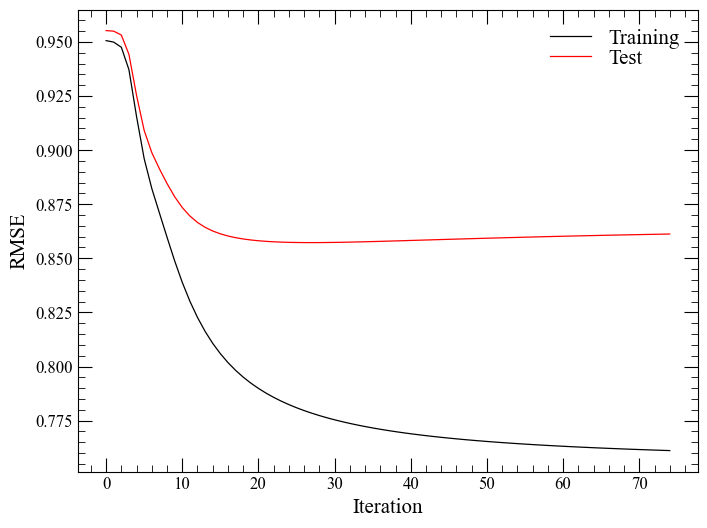

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(np.arange(0, rmse.shape[0], 1), rmse, lw = 0.9, color = 'black', label = 'Training')
ax.plot(np.arange(0, rmse_test.shape[0], 1), rmse_test, lw = 0.9, color = 'red', label = 'Test')

ax.set_xlabel('Iteration', fontsize = 15)
ax.set_ylabel('RMSE', fontsize = 15)
ax.legend(frameon = False, fontsize = 15)
ax.minorticks_on()
ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
ax.tick_params(which = 'major', length = 10, direction = 'in', labelsize = 12)
ax.tick_params(which = 'minor', length = 5, direction = 'in', labelsize = 12)
#plt.savefig('Mat_Fact.pdf', bbox_inches='tight')
